# Monte Carlo methods for the Travelling Salesman Problem

## Introduction

This notebook demonstrates Monte Carlo methods applied to combinatorial optimization through the classic Travelling Salesman Problem (TSP). The TSP asks: given a list of cities and the distances between them, what is the shortest possible route that visits each city exactly once and returns to the starting city?

While this problem appears simple, it belongs to the NP-hard complexity class, meaning that as the number of cities grows, the time required to find the optimal solution increases exponentially. For n cities, there are (n-1)!/2 possible routes, making brute force approaches infeasible for (roughly) n>15.

This notebook compares two approaches:
1. **Greedy Algorithm**: A deterministic heuristic that builds a route by always choosing the nearest unvisited city
2. **Simulated Annealing**: A Monte Carlo metaheuristic inspired by the physical process of annealing metals

## Theory

#### The Travelling Salesman Problem

Mathematically, the TSP can be formulated as finding a Hamiltonian cycle with minimum total weight. Given:
- A set of cities C = {c₁, c₂, ..., cₙ}
- A distance function d(cᵢ, cⱼ) representing the cost of travel between cities

We seek a permutation π of cities that minimizes:

`Total Distance = Σᵢ₌₁ⁿ d(π(i), π((i mod n) + 1))`

where the modular arithmetic ensures we return to the starting city.

#### Distance Calculation: Great Circle Distance

For geographic problems, we use the **Haversine formula** to calculate great circle distances on Earth's surface:

`d = 2R × arcsin(√(sin²(Δφ/2) + cos(φ₁)cos(φ₂)sin²(Δλ/2)))`

where:
- R = Earth's radius (6371 km)
- φ₁, φ₂ = latitudes in radians
- Δφ = φ₂ - φ₁
- Δλ = longitude difference in radians

#### Simulated Annealing Algorithm

Simulated annealing is inspired by the metallurgical process where materials are heated and slowly cooled to achieve crystal structures. The algorithm uses a **temperature parameter** T that controls the probability of accepting worse solutions via the Boltzmann distribution:

`P(accept worse solution) = exp(-ΔE/T)`

where ΔE is the change in objective function (route distance).

**Key Components:**
1. **Temperature Schedule**: T(k) = T₀ × α^k where α < 1 is the cooling rate
2. **Neighborhood Function**: Generate candidate solutions by swapping two random cities
3. **Acceptance Criterion**: Always accept better solutions; accept worse solutions with probability exp(-ΔE/T)

**Convergence Properties:**
- As T → 0, the algorithm becomes increasingly greedy
- High initial temperatures allow extensive exploration of the solution space
- Proper cooling schedules guarantee convergence to global optima (in infinite time)
- In practice, provides high-quality approximate solutions in polynomial time

In [115]:
import random
import math

import folium
import pandas as pd
import matplotlib.pyplot as pl

In [116]:
START = 'Bielsko-Biała'

In [117]:
data = pd.read_csv('data/cities.csv').set_index('city_name')
data

,lat,lon,population
city_name,,,
Warsaw,52.2297,21.0122,1790658
Kraków,50.0647,19.9450,779966
Łódź,51.7592,19.4560,679941
Wrocław,51.1079,17.0385,643782
Poznań,52.4064,16.9252,540372
Gdańsk,54.3520,18.6466,470907
Szczecin,53.4285,14.5528,401907
Bydgoszcz,53.1235,18.0084,339053
Lublin,51.2465,22.5684,338586


In [118]:
def add_cities_to_map(_data: pd.DataFrame, folim_map):
    """
    Add city markers to a Folium map for TSP visualization.

    This function creates interactive markers for each city in the dataset,
    with popups showing city names and home icons for visual clarity.

    Parameters
    ----------
    _data : pd.DataFrame
        DataFrame with city data indexed by city name,
        containing 'lat' and 'lon' columns for geographic coordinates
    folim_map : folium.Map
        Folium map object to which markers will be added

    Returns
    -------
    folium.Map
        The input map object with added city markers

    Examples
    --------
    >>> m = folium.Map(location=(52.0693, 19.4803), zoom_start=6)
    >>> m_with_cities = add_cities_to_map(city_data, m)
    """
    for city_name, city in _data.iterrows():
        folium.Marker(
            location=[city['lat'], city['lon']],
            popup=folium.Popup(
                f"<b>{city_name}</b>",
                max_width=200
            ),
            tooltip=city_name,
            icon=folium.Icon(color='red', icon='home')
        ).add_to(folim_map)
    return folim_map

In [119]:
m = folium.Map(location=(52.0693, 19.4803), zoom_start=6, tiles='OpenStreetMap')
add_cities_to_map(data, m)
m

In [120]:
def get_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    Returns
    -------
    float
        distance in kilometers
    """
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return 6371 * c

In [121]:
def cities_to_coords(_cities: list[str],
                     _data: pd.DataFrame) -> list[list[float]]:
    """
    Convert a list of city names to geographic coordinates
    for route visualization.

    This function transforms a TSP route (list of city names) into coordinate
    pairs suitable for plotting on maps. The function automatically closes
    the route by appending the starting city's coordinates to the end.

    Parameters
    ----------
    _cities : list[str]
        Ordered list of city names representing a TSP route
    _data : pd.DataFrame
        DataFrame with city data indexed by city name, containing 'lat' and 'lon'
        columns for geographic coordinates

    Returns
    -------
    list[list[float]]
        List of [latitude, longitude] coordinate pairs. If input is non-empty,
        the last element will be identical to the first, creating a closed tour.

    Examples
    --------
    >>> route = ['Warsaw', 'Kraków', 'Gdańsk']
    >>> coords = cities_to_coords(route, city_data)
    >>> len(coords) == len(route) + 1  # Closed tour
    True
    >>> coords[0] == coords[-1]  # Same start and end point
    True
    """
    res = []
    for city in _cities:
        res.append([
            _data.loc[city, 'lat'],
            _data.loc[city, 'lon']
        ])
    if _cities:
        res.append([
            _data.loc[_cities[0], 'lat'],
            _data.loc[_cities[0], 'lon']
        ])
    return res

In [122]:
def get_route_distance(_route: list[str], _data: pd.DataFrame) -> float:
    """
    Calculate the total distance of a complete TSP route
    including return journey.

    This function computes the sum of great circle distances between
    consecutive cities in a route, automatically including the return
    trip from the last city back to the first city.

    Parameters
    ----------
    _route : list[str]
        Ordered sequence of city names representing the tour.
        Must contain valid city names that exist in _data.index
    _data : pd.DataFrame
        City data indexed by city name with 'lat' and 'lon' columns
        containing geographic coordinates in decimal degrees

    Returns
    -------
    float
        Total route distance in kilometers, including the return journey
        to complete the closed tour

    Examples
    --------
    >>> route = ['Warsaw', 'Kraków', 'Gdańsk']
    >>> total_km = get_route_distance(route, city_data)
    >>> print(f"Total distance: {total_km:.1f} km")
    Total distance: 1020.4 km
    """
    res = 0
    for i in range(len(_route)):
        _current_city = _route[i]
        _next_city = _route[(i + 1) % len(_route)]  # Return to start

        res += get_distance(
            _data.loc[_current_city, 'lat'],
            _data.loc[_current_city, 'lon'],
            _data.loc[_next_city, 'lat'],
            _data.loc[_next_city, 'lon'],
        )
    return res

### Greedy Algorithm: Nearest Neighbor Heuristic

The nearest neighbor algorithm provides a simple, intuitive approach to the TSP:

1. **Start**: Begin at a designated starting city
2. **Iterate**: From current city, move to the nearest unvisited city
3. **Repeat**: Continue until all cities are visited
4. **Return**: Complete the tour by returning to the starting city

In [123]:
current_city = START
unvisited_cities = {
    city_name: [city['lat'], city['lon']]
    for city_name, city in data.iterrows() if city_name != current_city
}
naive_route = [current_city]

while unvisited_cities:
    distances = {
        city_name: get_distance(
            *coords,
            data.loc[current_city, 'lat'],
            data.loc[current_city, 'lon']
        )
        for city_name, coords in unvisited_cities.items()
    }
    nearest_city = min(distances, key=lambda x: distances[x])

    naive_route.append(nearest_city)
    current_city = nearest_city
    unvisited_cities.pop(current_city)

In [124]:
print(f'Total distance: {get_route_distance(naive_route, data):.0f} km')

Total distance: 3206 km


**Key Observations:**
- The greedy algorithm produces a tour in O(n²) time
- However, it can get trapped in locally optimal choices that lead to globally suboptimal solutions (see the jump to Szczecin which had been earlier omitted since other cities were closer)
- The algorithm's performance depends heavily on the choice of starting city

In [125]:
m = folium.Map(location=(52.0693, 19.4803), zoom_start=6, tiles='OpenStreetMap')
add_cities_to_map(data, m)
folium.PolyLine(
    locations=cities_to_coords(naive_route, data),
    weight=3,
    color='red',
    opacity=0.8,
).add_to(m)
m

In [126]:
class SimulatedAnnealing:
    """
    A simulated annealing solver for the Travelling Salesman Problem (TSP).

    This class implements the simulated annealing metaheuristic for finding
    approximate solutions to the TSP. The algorithm is inspired by
    the physical process of annealing metals, where controlled cooling
    allows the material to reach low-energy states. The key principle is that
    the algorithm is allowed to escape local minima by selecting suboptimal
    solutions. The acceptance probability is controlled by
    the Metropolis-Hastings criterion. Please find more details here:
        - https://en.wikipedia.org/wiki/Simulated_annealing
        - https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

    Mathematical Framework
    ----------------------
    The algorithm uses a temperature parameter T to control the probability
    of accepting worse solutions:

    P(accept worse solution) = exp(-ΔE/T)

    where ΔE is the increase in objective function (route distance).
    The acceptance probability follows the Boltzmann distribution.
    See: https://en.wikipedia.org/wiki/Boltzmann_distribution for more details.

    Temperature Schedule
    -------------------
    Uses geometric cooling: T(k+1) = α × T(k) where α < 1

    Algorithm Components
    --------------------
    1. **Neighborhood Generation**: Random 2-opt moves (city swaps)
    2. **Acceptance Criterion**: Metropolis criterion with temperature control
    3. **Cooling Schedule**: Exponential decay with configurable parameters
    4. **Termination**: Temperature threshold or maximum iterations

    Attributes
    ----------
    _data : pd.DataFrame
        City data with geographic coordinates
    _start : str
        Name of the starting city
    _route : list[str]
        Current best route found
    _cost : float
        Distance of the current best route
    _temperature : float
        Current temperature parameter
    _final_temp : float
        Minimum temperature for termination
    _cooling_rate : float
        Multiplicative cooling factor (0 < α < 1)
    _max_iterations : int
        Maximum number of iterations
    _cost_history : list[float]
        History of objective function values
    _temperature_history : list[float]
        History of temperature values

    Examples
    --------
    >>> solver = SimulatedAnnealing('Warsaw', city_data, 
    ...                            initial_temp=1000, 
    ...                            cooling_rate=0.99)
    >>> best_route = solver.solve()
    >>> print(f"Best distance: {solver._cost:.0f} km")
    Best distance: 2625 km
    >>> len(solver.cost_history)  # Iteration count
    5423
    """

    def __init__(self,
                 start: str,
                 _data: pd.DataFrame,
                 initial_temp=1e9,
                 final_temp=0,
                 cooling_rate=0.995,
                 max_iterations=10000):
        """
        Initialize simulated annealing solver with problem parameters.

        Parameters
        ----------
        start : str
            Name of the starting city (must be in _data.index)
        _data : pd.DataFrame
            City data indexed by city name with 'lat' and 'lon' columns
        initial_temp : float, default=5000
            Starting temperature. Higher values allow more exploration.
            Should be large enough that most moves are initially accepted.
        final_temp : float, default=0
            Termination temperature. Algorithm stops when T < final_temp.
        cooling_rate : float, default=0.995
            Geometric cooling factor (0 < α < 1). Smaller values cool faster.
            Typical range: 0.8-0.999
        max_iterations : int, default=10000
            Maximum number of iterations before forced termination
        """
        self._data = _data
        self._start = start

        _other_cities = [c for c in _data.index if c != start]
        random.shuffle(_other_cities)

        self._route = ([start] + _other_cities).copy()
        self._cost = get_route_distance(self._route, self._data)

        self._temperature = initial_temp
        self._final_temp = final_temp
        self._cooling_rate = cooling_rate
        self._max_iterations = max_iterations

        self._cost_history = [self._cost]
        self._temperature_history = [self._temperature]

    def solve(self) -> list[str]:
        """
        Execute the simulated annealing algorithm to find a TSP solution.

        The algorithm iteratively generates neighboring solutions by swapping
        two random cities and applies the Metropolis acceptance criterion.
        Temperature decreases geometrically until convergence.

        Algorithm Steps
        ---------------
        1. Generate neighbor by swapping two random cities
        2. Compute cost difference ΔE = new_cost - current_cost
        3. Accept if ΔE ≤ 0 (improvement) or with probability exp(-ΔE/T)
        4. Update the best solution if improvement found
        5. Cool temperature: T ← α×T
        6. Repeat until T < T_final or max iterations reached

        Returns
        -------
        list[str]
            Best route found as ordered list of city names.
            Route starts and ends at the specified starting city.

        Notes
        -----
        The algorithm maintains history in cost_history and
        temperature_history properties for convergence analysis.

        Convergence Properties
        ---------------------
        - Guaranteed to converge to global optimum in infinite time
            (when all possible routes are covered)
        - In practice, quickly finds a solution which approximates
            the best route
        - Quality depends on cooling schedule and neighborhood structure
            (might require parameter tuning)
        """
        i = 0
        while (self._temperature > self._final_temp and
               i < self._max_iterations):
            new_route = self._swap_random_neighbor()
            new_cost = get_route_distance(new_route, self._data)

            if self._metropolis_hastings_criterion(new_cost):
                current_route = new_route
                current_cost = new_cost

                if current_cost < self._cost:
                    self._route = current_route.copy()
                    self._cost = current_cost

            self._temperature *= self._cooling_rate
            i += 1

            self._cost_history.append(new_cost)
            self._temperature_history.append(self._temperature)

        return self._route

    def _metropolis_hastings_criterion(self, cost: float) -> bool:
        """
        Apply Metropolis-Hastings acceptance criterion for simulated annealing.

        Solutions that improve the objective function are always accepted.
        Worse solutions are accepted with probability exp(-ΔE/T), allowing
        escape from local optima when temperature is sufficiently high.

        At high temperatures, most moves are accepted (exploration phase).
        At low temperatures, only improvements are accepted (exploitation phase).

        Parameters
        ----------
        cost : float
            Cost (total distance) of the candidate solution to evaluate

        Returns
        -------
        bool
            True if the candidate solution should be accepted,
            False if it should be rejected
        """
        if cost < self._cost:
            return True
        else:
            return random.random() < math.exp(
                -(cost - self._cost) / self._temperature
            )

    @property
    def cost_history(self):
        """
        History of objective function values throughout the optimization.

        Returns
        -------
        list[float]
            Sequence of route distances evaluated at each iteration.
            Useful for analyzing convergence behavior and algorithm performance.
        """
        return self._cost_history

    @property
    def temperature_history(self):
        """
        History of temperature values throughout the cooling schedule.

        Returns
        -------
        list[float]
            Sequence of temperature parameters at each iteration.
            Useful for verifying proper cooling schedule implementation.
        """
        return self._temperature_history

    def _swap_random_neighbor(self) -> list[str]:
        """
        Generate a neighboring solution by swapping two random cities.

        This method implements a simple neighborhood structure for TSP.
        Two cities are randomly selected and their positions in the tour
        are exchanged, creating a new feasible solution.

        Returns
        -------
        list[str]
            New route with two cities swapped. The route remains a valid
            Hamiltonian cycle visiting all cities exactly once.
        """
        new_route = self._route.copy()

        i, j = random.sample(range(len(self._route)), 2)
        new_route[i], new_route[j] = new_route[j], new_route[i]

        return new_route

In [127]:
solver = SimulatedAnnealing(START, data)
optimized_route = solver.solve()

In [128]:
naive_distance = get_route_distance(naive_route, data)
optimized_distance = get_route_distance(optimized_route, data)

print(f'Total distance: {optimized_distance:.0f} km')
print(f'Total improvement {naive_distance - optimized_distance:.0f} km')
print(
    f'Ralative improvement {(naive_distance - optimized_distance) / naive_distance * 100:.2f} %')

Total distance: 2742 km
Total improvement 464 km
Ralative improvement 14.46 %


**Key Observations:**
- Simulated annealing significantly outperforms the greedy algorithm
- The improvement represents an **10% - 30% reduction** in total travel distance
- Results are different on each run - the solution is approximate

In [129]:
m = folium.Map(location=(52.0693, 19.4803), zoom_start=6, tiles='OpenStreetMap')
add_cities_to_map(data, m)
folium.PolyLine(
    locations=cities_to_coords(optimized_route, data),
    weight=3,
    color='red',
    opacity=0.8,
).add_to(m)
m

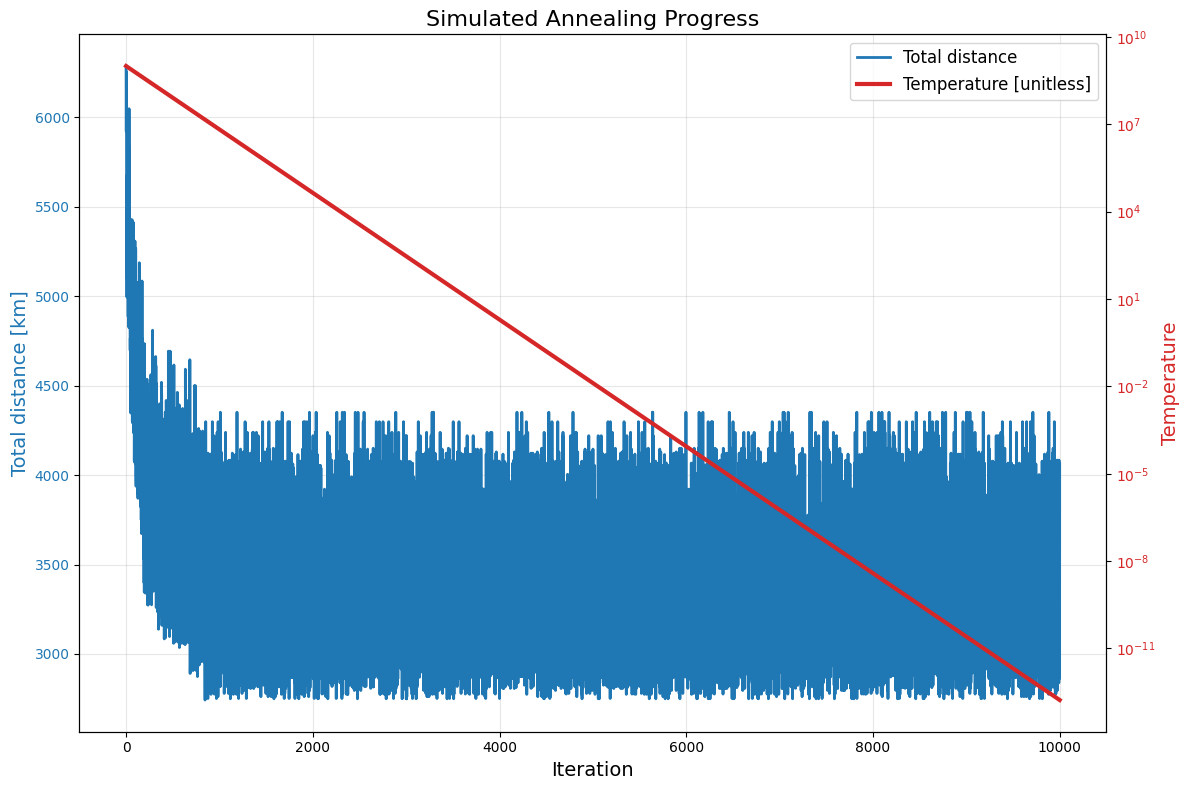

In [130]:
fig, ax1 = pl.subplots(figsize=(12, 8))

ax1.plot(solver.cost_history, color='tab:blue', label='Total distance',
         linewidth=2)
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Total distance [km]', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(solver.temperature_history, color='tab:red',
         label='Temperature [unitless]', linewidth=3)
ax2.set_ylabel('Temperature', fontsize=14, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Simulated Annealing Progress', fontsize=16)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12)

ax2.set_yscale('log')
pl.tight_layout()
pl.show()

## Conclusions and Extensions

### Key Takeaways

1. **Quick Approximation**: While our 21-city instance has ~10¹⁷ possible solutions, simulated annealing found a near-optimal tour in just 10,000 iterations

2. **Probabilistic Nature**: Simulated annealing is inherently stochastic, meaning that repeated executions of the algorithm can lead to noticeably different solutions

3. **Hyperparameter Sensitivity**: Simulated annealing is highly sensitive to its hyperparameters—such as the initial temperature, cooling schedule, and number of iterations—which must be carefully tuned for each specific task

### Computational Complexity

- **Greedy Algorithm**: O(n²) time, guaranteed but potentially poor solution quality
- **Simulated Annealing**: O(k×n) time where k is the number of iterations, much better solution quality
- **Optimal Solution**: O(n!) time using exhaustive search (infeasible for n > 15)

### Real-World Applications

The principles demonstrated here extend to numerous optimization problems:

- **Logistics**: Vehicle routing, supply chain optimization
- **Manufacturing**: Production scheduling, facility layout
- **VLSI Design**: Circuit placement and routing
- **Bioinformatics**: Protein folding, sequence alignment
- **Machine Learning**: Neural network training, hyperparameter optimization

### Extensions and Improvements

- **Advanced Neighborhoods**: 2-opt, 3-opt, Lin-Kernighan moves
- **Adaptive Cooling**: Temperature schedules based on solution quality
- **Hybrid Approaches**: Combine with genetic algorithms or tabu search